In [1]:
# Handle different types of transformation
# different nb of pixels
# different nb of level of gray

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import tree
import os
import random

mpl.rc('image', cmap='gray_r')
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import load_model

C:\Users\MariO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Useful methods

In [98]:
def rot90ccw(mat):
    """ Rotate an n by n matrix 90 deg counter clock wise"""
    
    # rotation matrix
    rot = np.array([[0, 1],
               [-1,0]])
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][0] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

def rot90cw(mat):
    """ Rotate an n by n matrix 90 deg clock wise"""
    
    # rotation matrix
    rot = np.array([[0, -1],
               [1,0]])    
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][1] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

In [100]:
# Transformation matrices
def create_PPstar_translation(nbpix):
    # nb of pixels translated
    nbt = int(np.round(0.25*nbpix))

    # bottom left square block
    bl = np.eye(nbpix-nbt,nbpix-nbt)
    # upper right square block
    ur = np.eye(nbt,nbt)
    # upper left rect block
    ul = np.zeros((nbt,nbpix-nbt))
    # bottom right rect block
    br = np.zeros((nbpix-nbt,nbt))

    # concatenate the blocks to build the transformation matrix
    P = np.concatenate((np.concatenate((ul,ur), axis=1), np.concatenate((bl,br), axis=1)), axis=0)
    Pstar = np.linalg.inv(P)        
    return (P,Pstar)

In [4]:
# plt.figure(1)
def remove_ticks():
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off    
    return

def vis_matrices(Mr, Mm, Mst, MstM):
#     print(Mr.shape[0])
    if Mr.shape[0]==1:
        Mr = Mr.reshape(int(np.sqrt(Mr.shape[1])), int(np.sqrt(Mr.shape[1])))
        Mm = Mm.reshape(int(np.sqrt(Mm.shape[1])), int(np.sqrt(Mm.shape[1])))
        Mst = Mst.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))
        MstM = MstM.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))

    
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=2) #, squeeze=True, sharey=True)
    fig.set_size_inches(8,8)

    plt.sca(ax1[0])
    plt.imshow(Mr)
    plt.title("Real image")
    remove_ticks()

    plt.sca(ax2[0])
    plt.imshow(Mm)
    plt.title("Distorted image")
    remove_ticks()

    plt.sca(ax1[1])
    plt.imshow(Mst)
    plt.title("Corrected input")
    remove_ticks()

    plt.sca(ax2[1])
    plt.imshow(MstM)
    plt.title("Corrected visualization")
    remove_ticks()

In [5]:
def create_training_data(nbpix,nb_lvl_gray=1):
    """
    Build the set of one pixel matrices and apply the transformations
    """
    # List of indexes where to put a black pixel
    idx = range(0,nbpix**2,1)

    # Initialize empty arrays 
    Mreal_tab = np.zeros((len(idx),nbpix*nbpix))
    Mmang_tab = np.zeros((len(idx),nbpix*nbpix))
    Mstar_tab = np.zeros((len(idx),nbpix*nbpix))
    for ii in idx:
        # Fill the indexed pixel with a one
        Mreal_tab[ii,ii] = 1
        # Use the transformation matrices to generate Mmang and Mstar
        Mmang_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@P).reshape(1,nbpix**2)
        Mstar_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@Pstar).reshape(1,nbpix**2)
    return (Mreal_tab, Mmang_tab, Mstar_tab)

In [6]:
# Function to add one on the designated index
def add_one(arr,index):
    arr[0,index] = 1
    return arr

# Function to split the matrix into matrices of one pixel
def split_matrix(mat):
    """ Split a matrix into matrices of one pixel"""
    # find the indexes of the ones values in the matrix
    idx_arr = np.where(mat.reshape(1,nbpix**2)[0]==1)[0]
    # transform from an array to a list
    idx_lst = [idx_arr.item(ii) for ii in range(0,len(idx_arr))] 
    temp = np.zeros((1,nbpix**2))
    mat_split = np.zeros((len(idx_lst), nbpix**2))
#     Mtest = np.zeros((nbpix,nbpix))
    for ii in range(0,len(idx_lst)):
        mat_split[ii,idx_lst[ii]] = 1    
#         Mtest = Mtest + Mreal_split[ii,:].reshape(nbpix,nbpix)
    return mat_split

In [7]:
# Prediction functions
def predict_mangler(mat):
    # split the input matrix into matrices of one pixel
    mat_split = split_matrix(mat)
    nb_dark_pxl = mat_split.shape[0]
    
    # initializations
    res = np.zeros((nb_dark_pxl, nbpix**2))
    Mres = np.zeros((nbpix,nbpix))
    # Loop on all the one pixels array
    for ii in range(0,nb_dark_pxl):
        # Apply the models to the one pixel matrices
        res[ii,:] = model_mangler.predict(np.expand_dims(mat_split[ii], axis=0))
        # Sum up the results to construct the matrices
        Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
    return Mres

def predict_corrector(mat):
    # split the input matrix into matrices of one pixel
    mat_split = split_matrix(mat)
    nb_dark_pxl = mat_split.shape[0]
    
    # initializations
    res = np.zeros((nb_dark_pxl, nbpix**2))
    Mres = np.zeros((nbpix,nbpix))
    # Loop on all the one pixels array
    for ii in range(0,nb_dark_pxl):
        # Apply the models to the one pixel matrices
        res[ii,:] = model_corrector.predict(np.expand_dims(mat_split[ii], axis=0))
        # Sum up the results to construct the matrices
        Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
    return Mres

In [8]:
def create_door_img(nbpix):
    """ Create an nbpix by nbpix image of a door"""
    nbborder = int(np.round(nbpix*0.3))
    u = np.ones((nbborder,nbpix))
    l = np.ones((nbpix-nbborder,nbborder))
    r = l
    door = np.zeros((nbpix-nbborder, nbpix-2*nbborder))

    return np.concatenate((u,np.concatenate((l,door,r), axis=1)), axis=0)

 ## MAIN

In [39]:
# Parameters
nbpix = 3 # nb of pixel to consider (nbpix x nbpix)
transform_type = "translation" # type of transformation
nb_lvl_gray = 1 # nb of level of gray

In [10]:
# create the transformation matrices


(P,Pstar) = create_PPstar(nbpix)

# Create the training data
(Mreal_tab, Mmang_tab, Mstar_tab) = create_training_data(nbpix,1)
idx = range(0,nbpix**2,1)

# the training input are the matrices of the real images with one pixel
X_train = Mreal_tab

# the training output will be the category corresponding to the position of the pixel in the mangled image
y_train = [np.where(Mmang_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train = to_categorical(y_train, nbpix**2)

# or the position of the pixel in the corrected image
y_train_cor = [np.where(Mstar_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train_cor = to_categorical(y_train_cor, nbpix**2)

# creating the models
model_mangler = Sequential()
model_mangler.add(Dense(4*nbpix**2, activation='relu', input_dim=nbpix**2))
model_mangler.add(Dense(4*nbpix**2, activation='relu'))
model_mangler.add(Dense(nbpix**2, activation='softmax'))
# Inversion strategy doesnt work very well...
# we are going to try using another model, trained on the corrected input.
model_corrector = Sequential()
model_corrector.add(Dense(4*nbpix**2, activation='relu', input_dim=nbpix**2))
model_corrector.add(Dense(4*nbpix**2, activation='relu'))
model_corrector.add(Dense(nbpix**2, activation='softmax'))

# Compile the models
model_mangler.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model_corrector.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

# train the model "mangler"
model_mangler.fit( X_train,
    y_train,
    epochs=5*nbpix**2,
    shuffle=True,
    verbose=1
)

# train the corrected input model
model_corrector.fit( X_train,
    y_train_cor,
    epochs=5*nbpix**2,
    shuffle=True,
    verbose=1
)    

# model_mangler.summary()
# model_corrector.summary()

# Save the models
model_mangler.save(f"{transform_type}_mangler_{nbpix}x{nbpix}.h5")
model_corrector.save(f"{transform_type}_corrector_{nbpix}x{nbpix}.h5")


Epoch 1/405
81/81 [==============================] - 0s 4ms/step - loss: 4.3998 - acc: 0.0000e+00
Epoch 2/405
81/81 [==============================] - 0s 296us/step - loss: 4.3372 - acc: 0.1852
Epoch 3/405
81/81 [==============================] - 0s 235us/step - loss: 4.2846 - acc: 0.5432
Epoch 4/405
81/81 [==============================] - 0s 309us/step - loss: 4.2307 - acc: 0.7407
Epoch 5/405
81/81 [==============================] - 0s 346us/step - loss: 4.1749 - acc: 0.8519
Epoch 6/405
81/81 [==============================] - 0s 333us/step - loss: 4.1130 - acc: 0.9506
Epoch 7/405
81/81 [==============================] - 0s 259us/step - loss: 4.0449 - acc: 0.9753
Epoch 8/405
81/81 [==============================] - 0s 333us/step - loss: 3.9712 - acc: 0.9877
Epoch 9/405
81/81 [==============================] - 0s 272us/step - loss: 3.8884 - acc: 1.0000
Epoch 10/405
81/81 [==============================] - 0s 259us/step - loss: 3.7964 - acc: 1.0000
Epoch 11/405
81/81 [=================

81/81 [==============================] - 0s 210us/step - loss: 0.0080 - acc: 1.0000
Epoch 86/405
81/81 [==============================] - 0s 185us/step - loss: 0.0079 - acc: 1.0000
Epoch 87/405
81/81 [==============================] - 0s 185us/step - loss: 0.0077 - acc: 1.0000
Epoch 88/405
81/81 [==============================] - 0s 185us/step - loss: 0.0075 - acc: 1.0000
Epoch 89/405
81/81 [==============================] - 0s 210us/step - loss: 0.0074 - acc: 1.0000
Epoch 90/405
81/81 [==============================] - 0s 222us/step - loss: 0.0072 - acc: 1.0000
Epoch 91/405
81/81 [==============================] - 0s 235us/step - loss: 0.0071 - acc: 1.0000
Epoch 92/405
81/81 [==============================] - 0s 235us/step - loss: 0.0069 - acc: 1.0000
Epoch 93/405
81/81 [==============================] - 0s 259us/step - loss: 0.0068 - acc: 1.0000
Epoch 94/405
81/81 [==============================] - 0s 247us/step - loss: 0.0066 - acc: 1.0000
Epoch 95/405
81/81 [=======================

81/81 [==============================] - 0s 185us/step - loss: 0.0023 - acc: 1.0000
Epoch 169/405
81/81 [==============================] - 0s 185us/step - loss: 0.0022 - acc: 1.0000
Epoch 170/405
81/81 [==============================] - 0s 210us/step - loss: 0.0022 - acc: 1.0000
Epoch 171/405
81/81 [==============================] - 0s 210us/step - loss: 0.0022 - acc: 1.0000
Epoch 172/405
81/81 [==============================] - 0s 222us/step - loss: 0.0022 - acc: 1.0000
Epoch 173/405
81/81 [==============================] - 0s 235us/step - loss: 0.0021 - acc: 1.0000
Epoch 174/405
81/81 [==============================] - 0s 222us/step - loss: 0.0021 - acc: 1.0000
Epoch 175/405
81/81 [==============================] - 0s 222us/step - loss: 0.0021 - acc: 1.0000
Epoch 176/405
81/81 [==============================] - 0s 235us/step - loss: 0.0021 - acc: 1.0000
Epoch 177/405
81/81 [==============================] - 0s 210us/step - loss: 0.0021 - acc: 1.0000
Epoch 178/405
81/81 [=============

81/81 [==============================] - 0s 210us/step - loss: 0.0011 - acc: 1.0000
Epoch 252/405
81/81 [==============================] - 0s 210us/step - loss: 0.0011 - acc: 1.0000
Epoch 253/405
81/81 [==============================] - 0s 222us/step - loss: 0.0011 - acc: 1.0000
Epoch 254/405
81/81 [==============================] - 0s 185us/step - loss: 0.0011 - acc: 1.0000
Epoch 255/405
81/81 [==============================] - 0s 222us/step - loss: 0.0010 - acc: 1.0000
Epoch 256/405
81/81 [==============================] - 0s 198us/step - loss: 0.0010 - acc: 1.0000
Epoch 257/405
81/81 [==============================] - 0s 247us/step - loss: 0.0010 - acc: 1.0000
Epoch 258/405
81/81 [==============================] - 0s 222us/step - loss: 0.0010 - acc: 1.0000
Epoch 259/405
81/81 [==============================] - 0s 222us/step - loss: 0.0010 - acc: 1.0000
Epoch 260/405
81/81 [==============================] - 0s 247us/step - loss: 0.0010 - acc: 1.0000
Epoch 261/405
81/81 [=============

81/81 [==============================] - 0s 222us/step - loss: 6.3954e-04 - acc: 1.0000
Epoch 332/405
81/81 [==============================] - 0s 185us/step - loss: 6.3592e-04 - acc: 1.0000
Epoch 333/405
81/81 [==============================] - 0s 222us/step - loss: 6.3230e-04 - acc: 1.0000
Epoch 334/405
81/81 [==============================] - 0s 210us/step - loss: 6.2868e-04 - acc: 1.0000
Epoch 335/405
81/81 [==============================] - 0s 210us/step - loss: 6.2509e-04 - acc: 1.0000
Epoch 336/405
81/81 [==============================] - 0s 235us/step - loss: 6.2156e-04 - acc: 1.0000
Epoch 337/405
81/81 [==============================] - 0s 222us/step - loss: 6.1806e-04 - acc: 1.0000
Epoch 338/405
81/81 [==============================] - 0s 222us/step - loss: 6.1459e-04 - acc: 1.0000
Epoch 339/405
81/81 [==============================] - 0s 235us/step - loss: 6.1104e-04 - acc: 1.0000
Epoch 340/405
81/81 [==============================] - 0s 222us/step - loss: 6.0766e-04 - acc: 1

81/81 [==============================] - 0s 173us/step - loss: 4.1102 - acc: 1.0000
Epoch 7/405
81/81 [==============================] - 0s 173us/step - loss: 4.0402 - acc: 1.0000
Epoch 8/405
81/81 [==============================] - 0s 198us/step - loss: 3.9628 - acc: 1.0000
Epoch 9/405
81/81 [==============================] - 0s 173us/step - loss: 3.8781 - acc: 1.0000
Epoch 10/405
81/81 [==============================] - 0s 198us/step - loss: 3.7831 - acc: 1.0000
Epoch 11/405
81/81 [==============================] - 0s 198us/step - loss: 3.6770 - acc: 1.0000
Epoch 12/405
81/81 [==============================] - 0s 222us/step - loss: 3.5602 - acc: 1.0000
Epoch 13/405
81/81 [==============================] - 0s 222us/step - loss: 3.4323 - acc: 1.0000
Epoch 14/405
81/81 [==============================] - 0s 222us/step - loss: 3.2928 - acc: 1.0000
Epoch 15/405
81/81 [==============================] - 0s 222us/step - loss: 3.1411 - acc: 1.0000
Epoch 16/405
81/81 [==========================

81/81 [==============================] - 0s 198us/step - loss: 0.0072 - acc: 1.0000
Epoch 91/405
81/81 [==============================] - 0s 173us/step - loss: 0.0071 - acc: 1.0000
Epoch 92/405
81/81 [==============================] - 0s 222us/step - loss: 0.0069 - acc: 1.0000
Epoch 93/405
81/81 [==============================] - 0s 185us/step - loss: 0.0068 - acc: 1.0000
Epoch 94/405
81/81 [==============================] - 0s 198us/step - loss: 0.0066 - acc: 1.0000
Epoch 95/405
81/81 [==============================] - 0s 222us/step - loss: 0.0065 - acc: 1.0000
Epoch 96/405
81/81 [==============================] - 0s 222us/step - loss: 0.0064 - acc: 1.0000
Epoch 97/405
81/81 [==============================] - 0s 259us/step - loss: 0.0063 - acc: 1.0000
Epoch 98/405
81/81 [==============================] - 0s 235us/step - loss: 0.0061 - acc: 1.0000
Epoch 99/405
81/81 [==============================] - 0s 222us/step - loss: 0.0060 - acc: 1.0000
Epoch 100/405
81/81 [======================

81/81 [==============================] - 0s 185us/step - loss: 0.0021 - acc: 1.0000
Epoch 174/405
81/81 [==============================] - 0s 185us/step - loss: 0.0021 - acc: 1.0000
Epoch 175/405
81/81 [==============================] - 0s 210us/step - loss: 0.0021 - acc: 1.0000
Epoch 176/405
81/81 [==============================] - 0s 185us/step - loss: 0.0021 - acc: 1.0000
Epoch 177/405
81/81 [==============================] - 0s 185us/step - loss: 0.0021 - acc: 1.0000
Epoch 178/405
81/81 [==============================] - 0s 210us/step - loss: 0.0020 - acc: 1.0000
Epoch 179/405
81/81 [==============================] - 0s 222us/step - loss: 0.0020 - acc: 1.0000
Epoch 180/405
81/81 [==============================] - 0s 235us/step - loss: 0.0020 - acc: 1.0000
Epoch 181/405
81/81 [==============================] - 0s 210us/step - loss: 0.0020 - acc: 1.0000
Epoch 182/405
81/81 [==============================] - 0s 222us/step - loss: 0.0020 - acc: 1.0000
Epoch 183/405
81/81 [=============

81/81 [==============================] - 0s 222us/step - loss: 0.0010 - acc: 1.0000
Epoch 257/405
81/81 [==============================] - 0s 198us/step - loss: 0.0010 - acc: 1.0000
Epoch 258/405
81/81 [==============================] - 0s 173us/step - loss: 0.0010 - acc: 1.0000
Epoch 259/405
81/81 [==============================] - 0s 210us/step - loss: 0.0010 - acc: 1.0000
Epoch 260/405
81/81 [==============================] - 0s 198us/step - loss: 0.0010 - acc: 1.0000
Epoch 261/405
81/81 [==============================] - 0s 235us/step - loss: 9.9985e-04 - acc: 1.0000
Epoch 262/405
81/81 [==============================] - 0s 235us/step - loss: 9.9279e-04 - acc: 1.0000
Epoch 263/405
81/81 [==============================] - 0s 259us/step - loss: 9.8570e-04 - acc: 1.0000
Epoch 264/405
81/81 [==============================] - 0s 222us/step - loss: 9.7879e-04 - acc: 1.0000
Epoch 265/405
81/81 [==============================] - 0s 222us/step - loss: 9.7173e-04 - acc: 1.0000
Epoch 266/405


81/81 [==============================] - 0s 198us/step - loss: 6.2045e-04 - acc: 1.0000
Epoch 337/405
81/81 [==============================] - 0s 185us/step - loss: 6.1692e-04 - acc: 1.0000
Epoch 338/405
81/81 [==============================] - 0s 222us/step - loss: 6.1347e-04 - acc: 1.0000
Epoch 339/405
81/81 [==============================] - 0s 210us/step - loss: 6.0997e-04 - acc: 1.0000
Epoch 340/405
81/81 [==============================] - 0s 198us/step - loss: 6.0664e-04 - acc: 1.0000
Epoch 341/405
81/81 [==============================] - 0s 235us/step - loss: 6.0315e-04 - acc: 1.0000
Epoch 342/405
81/81 [==============================] - 0s 222us/step - loss: 5.9982e-04 - acc: 1.0000
Epoch 343/405
81/81 [==============================] - 0s 247us/step - loss: 5.9649e-04 - acc: 1.0000
Epoch 344/405
81/81 [==============================] - 0s 198us/step - loss: 5.9320e-04 - acc: 1.0000
Epoch 345/405
81/81 [==============================] - 0s 222us/step - loss: 5.8987e-04 - acc: 1

In [11]:
# Apply the models to an existing image

# Load the saved models
model_mangler = load_model(f"{transform_type}_mangler_{nbpix}x{nbpix}.h5")
model_corrector = load_model(f"{transform_type}_corrector_{nbpix}x{nbpix}.h5")

In [40]:
# Mreal = create_door_img(nbpix) 
cut = 0.5
Mreal = np.random.choice([0, 1], size=(nbpix,nbpix), p=[ 1-cut, cut])
# Mreal_split = split_matrix(Mreal)

# Predict the mangled image based on the real one
Mmang_ml = predict_mangler(Mreal)
# Predict the corrected input based on the real image
Mcor_ml = predict_corrector(Mreal)
# Prediction the output from the corrected input
Mout_ml = predict_mangler(np.round(Mcor_ml))
# plot the results
vis_matrices(Mreal, Mmang_ml,Mcor_ml, Mout_ml)

ValueError: Error when checking input: expected dense_1_input to have shape (81,) but got array with shape (9,)

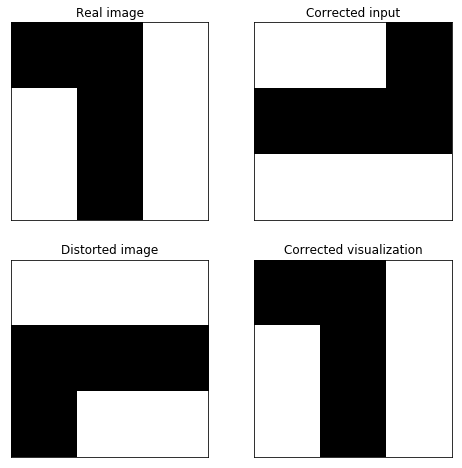

In [99]:
vis_matrices(Mreal, rot90ccw(Mreal),rot90cw(Mreal), rot90ccw(rot90cw(Mreal)))